In [2]:
import tensorflow as tf

## 1. Positional Encoding
$$PE_{(pos, 2i)} = sin(pos/10000^{2i/EmbeddingDimension})$$
$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/EmbeddingDimension})$$

In [3]:
def create_position_encoding(sequence_length, d_embedding):
    """
    Args:
        sequence_length: the length of input sequence. 
        d_embedding: the dimension of the embedding space. i.e 
    Returns:
        positional_encoding: shape (1, sequence_length, d_embedding)
        Note: the output is unsequeeze at dimension 1 to enable easier broadcasting
    """
    
    # position[i] = the i-th index the sequence
    positions = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]
    # embedding_indices[i] = the i-th index in the embedding 
    # Note: embedding_indices has length d_embedding/2, because sin and cos share the same input
    # e.g [0, 2, 4, 6] for d_embeddingn = 8
    embedding_indices = tf.range(d_embedding, delta=2, dtype=tf.float32)[tf.newaxis:]
    
    # inner = pos/10000^(2i/EmbeddingDimension), i.e the input to sin and cos
    inner = positions / 10000**(embedding_indices/tf.cast(d_embedding, tf.float32))
    sin_position_encodings = tf.math.sin(inner)
    cos_position_encodings = tf.math.cos(inner)
    # to create alternating sin and cos encodings, we use a hack: we expand dim at the last axis and concatenate the resulting tensors
    sin_position_encodings = tf.expand_dims(sin_position_encodings, axis=-1)
    cos_position_encodings = tf.expand_dims(cos_position_encodings, axis=-1)
    position_encodings = tf.concat([sin_position_encodings, cos_position_encodings], axis=-1)
    position_encodings = tf.reshape(position_encodings, (1, sequence_length, d_embedding))
    return position_encodings

In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, embeddings):
        embedding_shape = tf.shape(embeddings)
        sequence_length = embedding_shape[-2]
        d_embedding = embedding_shape[-1]
        position_encoding = self.create_position_encoding(sequence_length, d_embedding)
        embeddings += position_encoding
        return embeddings
        
    def create_position_encoding(self, sequence_length, d_embedding):
        """
        Args:
            sequence_length: the length of input sequence. 
            d_embedding: the dimension of the embedding space. i.e 
        Returns:
            positional_encoding: shape (1, sequence_length, d_embedding)
            Note: the output is unsequeeze at dimension 1 to enable easier broadcasting
        """

        # position[i] = the i-th index the sequence
        positions = tf.range(sequence_length, dtype=tf.float32)[:, tf.newaxis]
        # embedding_indices[i] = the i-th index in the embedding 
        # Note: embedding_indices has length d_embedding/2, because sin and cos share the same input
        # e.g [0, 2, 4, 6] for d_embedding = 8
        embedding_indices = tf.range(d_embedding, delta=2, dtype=tf.float32)[tf.newaxis:]

        # inner = pos/10000^(2i/EmbeddingDimension), i.e the input to sin and cos
        inner = positions / 10000**(embedding_indices/tf.cast(d_embedding, tf.float32))
        sin_position_encodings = tf.math.sin(inner)
        cos_position_encodings = tf.math.cos(inner)
        # to create alternating sin and cos encodings, we use a hack: we expand dim at the last axis and concatenate the resulting tensors
        sin_position_encodings = tf.expand_dims(sin_position_encodings, axis=-1)
        cos_position_encodings = tf.expand_dims(cos_position_encodings, axis=-1)
        position_encodings = tf.concat([sin_position_encodings, cos_position_encodings], axis=-1)
        position_encodings = tf.reshape(position_encodings, (1, sequence_length, d_embedding))
        return position_encodings

In [5]:
PE = create_position_encoding(sequence_length=100, d_embedding=512)
PE.shape

TensorShape([1, 100, 512])

## 2. look_ahead Masking & Padding Masking
####    look_ahead Masking outputs 1s on positions which the decoder should NOT be looking at.
####    Padding Maskings outputs 1s on positions which are padded.

In [6]:
def create_look_ahead_mask(sequence_length):
    """
    Args:
        sequence_length: the length of input sequence
    Returns:
        look_ahead_mask: shape (sequence_length, sequence_length)
        
    e.g
    sequence_lenght = 3
    look_ahead_mask = [
        [0, 1, 1], on predicting the 1st word, only the 0th word (the <START/> token) will be used
        [0, 0, 1], on predicting the 2nd word, only the 1st word and the 0th word can be used
        [0, 0, 0]  and so on
    ]
    """
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)
    return look_ahead_mask

In [7]:
look_ahead_mask = create_look_ahead_mask(3)
look_ahead_mask

<tf.Tensor: id=45, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [8]:
def create_padding_mask(sparse_input_sequence):
    """
    Args:
        sparse_input_sequence: shape(batch_size, sequence_length) e.g [0, 1, 3, 0, 5, 13]
    Returns:
        padding_mask: boolean mask where 1s indicates padding. e.g [1, 0, 0, 1, 0, 0] for the example input
    """
    mask = tf.cast(tf.math.equal(sparse_input_sequence, 0), tf.float32)
    return mask

In [9]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=49, shape=(3, 5), dtype=float32, numpy=
array([[0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1.],
       [1., 1., 1., 0., 0.]], dtype=float32)>

## 3. Attention
$$Attention(Q, K, V) = softmax(\dfrac{QK^T}{\sqrt{d_v}})V$$

## 4. Multi-head Attention

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        """
        Args: 
            d_model: the dimension of input/output of each sublayer in the encoder/decoder

            n_heads: number of heads to split
        Returns:
            aggregated_attention: aggregated multihead attention using a final dense layer
        """
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # number of heads must be divisible by model dimension
        assert d_model % self.n_heads == 0
        
        self.depth = d_model // n_heads # depth of q, k, v
        

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.wout = tf.keras.layers.Dense(d_model)
        
        
    def call(self, query_sequence, key_sequence, value_sequence, mask=None):
        batch_size = tf.shape(query_sequence)[0]
        
        q = self.wq(query_sequence)
        k = self.wk(key_sequence)
        v = self.wv(value_sequence)
        
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        attention = self.calculate_attention(q, k, v, mask) # (batch_size, n_heads, seq_len_q, depth)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, n_heads, depth)
        attention = tf.reshape(attention, (batch_size, -1, self.d_model))
        
        return self.wout(attention)
        
    def split_heads(self, x):
        """Split the last dimension into (n_heads, depth).
        Transpose the result such that the shape is (batch_size, n_heads, seq_len, depth)
        """
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.depth)) # (batch_size, seq_len, n_heads, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3]) # (batch_size, n_heads, seq_len, depth)
    
    def calculate_attention(self, q, k, v, mask):
        """
        assume depth = depth_q = depth_k = depth_v
        Args:
            q: query shape == (..., seq_len_q, depth)
            k: key shape == (..., seq_len_k, depth)
            v: value shape == (..., seq_len_v, depth)
            mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k).

        Returns:
            attention: shape (..., seq_len_q, depth_v)
        """

        logit = tf.matmul(q, k, transpose_b=True) # Q matmul K_Tranpose
        sqrt_d = tf.math.sqrt(tf.cast(self.depth, tf.float32)) # sqrt(d)
        logit = tf.truediv(logit, sqrt_d) # QK_t/sqrt(d_v)
        if(mask is not None):
            logit += mask*1e-9 # make logits of words that shouldn't be used -inf, so after softmax they will be close to 0
        attention_weights = tf.nn.softmax(logit, axis=-1)
        attention = tf.matmul(attention_weights, v)
        return attention

In [11]:
test_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)
test_v = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)
test_q = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)


In [ ]:
temp_mha = MultiHeadAttention(d_model=512, n_heads=8)
y = tf.random.uniform((5, 16))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y, y, y, mask=None)
out.shape, attn.shape

In [23]:
class PointWiseFeedForwardDense(tf.keras.layers.Layer):
    def __init__(self, d_model , d_ff):
        """
        Args:
            d_model: dimension of the encoder/decoder
            d_ff: dimension of the intermediate layer
        """
        super().__init__()
        self.dense_hidden = tf.keras.layers.Dense(d_ff, activation='relu')
        self.dense_out = tf.keras.layers.Dense(d_model)
        
    def call(self, inputs):
        x = self.dense_hidden(inputs)
        x = self.dense_out(x)
        return x
    

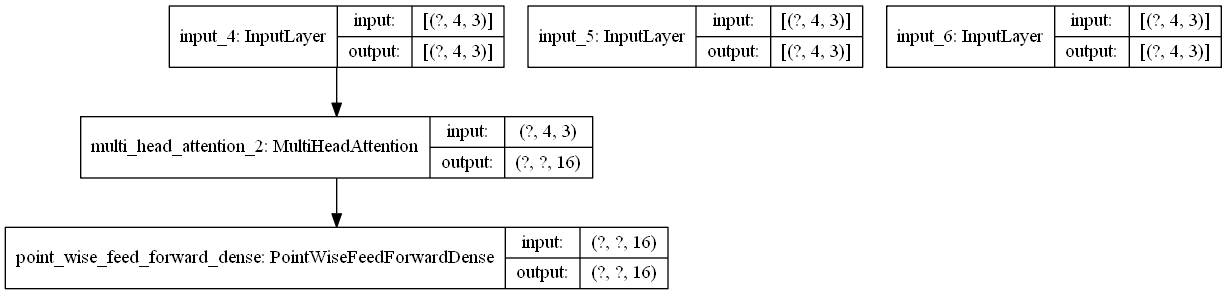

In [24]:
k_in = tf.keras.Input(shape=(4,3), dtype='float32')
v_in = tf.keras.Input(shape=(4,3), dtype='float32')
q_in = tf.keras.Input(shape=(4,3), dtype='float32')
out = MultiHeadAttention(16, 2)(k_in, v_in, q_in)
out = PointWiseFeedForwardDense(16, 32)(out)
model = tf.keras.Model([k_in, v_in, q_in], out)
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, feed_forward_d_ff, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, n_heads)

        self.ffn = PointWiseFeedForwardDense(d_model, feed_forward_d_ff)

        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, is_training, padding_mask):
        attention = self.mha(x, x, x, padding_mask)
        attention = self.dropout1(attention, training=is_training)
        output1 = self.layernorm1(attention + x)
        
        ffoutput = self.ffn(output1)
        ffoutput = self.dropout2(ffoutput, training=is_training)
        output2 = self.layernorm2(ffoutput + output1)
        return output2

In [61]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [62]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, feed_forward_d_ff, dropout_rate=0.1):
        super().__init__()
        self.mha_decoder_decoder = MultiHeadAttention(d_model, n_heads)
        self.mha_encoder_decoder = MultiHeadAttention(d_model, n_heads)
        self.ffn = PointWiseFeedForwardDense(d_model, feed_forward_d_ff)

        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, encoder_output, is_training, look_ahead_mask, padding_mask):
        self_attention = self.mha_decoder_decoder(x, x, x, look_ahead_mask)
        self_attention = self.dropout1(self_attention, training=is_training)
        output1 = self.layernorm1(self_attention + x)
        
        encoder_decoder_attention = self.mha_encoder_decoder(output1, encoder_output, encoder_output, padding_mask)
        encoder_decoder_attention = self.dropout2(encoder_decoder_attention, training=is_training)
        output2 = self.layernorm2(encoder_decoder_attention + output1)
        
        ffoutput = self.ffn(output2)
        ffoutput = self.dropout3(ffoutput, training=is_training)
        output3 = self.layernorm3(ffoutput + output2)
        return output3

In [63]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [64]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, d_model, n_layers, n_heads, d_ff, dropout_rate=0.1):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.position_encoding = PositionalEncoding()
        self.encoder_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout_rate) for _ in range(n_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, is_training, padding_mask):
        """
        Args: 
            position_encoded_embeddings: shape (batch size, sequence length, embedding dimension)
        """
        x = self.embedding(x)
        x = self.position_encoding(x)
        x = self.dropout(x)
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, is_training, padding_mask)
        return x # x.shape == (batch_size, input_seq_len, d_model)

In [65]:
sample_encoder = Encoder(n_layers=2, d_model=512, n_heads=8, 
                         d_ff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, is_training=False, padding_mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [66]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, d_model, n_layers, n_heads, d_ff, dropout_rate=0.1):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(output_vocab_size, d_model)
        self.position_encoding = PositionalEncoding()
        self.decoder_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout_rate) for _ in range(n_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, encoder_output, is_training, look_ahead_mask, padding_mask):
        x = self.embedding(x)
        x = self.position_encoding(x)
        x = self.dropout(x)
        for decoder_layer in self.decoder_layers:
            x = decoder_layer(x, encoder_output, is_training, look_ahead_mask, padding_mask)
        return x # x.shape == (batch_size, target_seq_len, d_model)

In [67]:
sample_decoder = Decoder(n_layers=2, d_model=512, n_heads=8, 
                         d_ff=2048, output_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output = sample_decoder(temp_input, 
                              encoder_output=sample_encoder_output, 
                              is_training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape

TensorShape([64, 26, 512])

In [74]:
class Transformer(tf.keras.Model):
    def __init__(self, input_vocab_size, output_vocab_size, d_model, n_layers, n_heads, d_ff, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(input_vocab_size, d_model, n_layers, n_heads, d_ff, dropout_rate)
        self.decoder = Decoder(output_vocab_size, d_model, n_layers, n_heads, d_ff, dropout_rate)
        self.final_output_dense = tf.keras.layers.Dense(output_vocab_size) # map decoder output from d_model to output_vocab_size
    
    def call(self, encoder_input_sequence, decoder_input_sequence, is_training=False, encoder_padding_mask=None, 
           look_ahead_mask=None, decoder_padding_mask=None):
        encoder_output = self.encoder(encoder_input_sequence, is_training, encoder_padding_mask)
        decoder_output = self.decoder(decoder_input_sequence, encoder_output, is_training, look_ahead_mask, decoder_padding_mask)
        output = self.final_output_dense(decoder_output)
        return output

In [75]:
transformer = Transformer(n_layers=2, d_model=512, n_heads=8, d_ff=2048, 
    input_vocab_size=8500, output_vocab_size=8000)

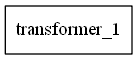

In [76]:
tf.keras.utils.plot_model(transformer, show_shapes=True, expand_nested=True)

In [77]:
encoder_input_sequence = tf.keras.layers.Input((32, 50))
decoder_input_sequence = tf.keras.layers.Input((32, 25))

output = transformer(encoder_input_sequence, decoder_input_sequence)
model = tf.keras.Model([encoder_input_sequence, decoder_input_sequence], output)

In [78]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 50)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 32, 25)]     0                                            
__________________________________________________________________________________________________
transformer_1 (Transformer)     (None, 32, 25, 8000) 27264832    input_9[0][0]                    
Total params: 27,264,832
Trainable params: 27,264,832
Non-trainable params: 0
__________________________________________________________________________________________________


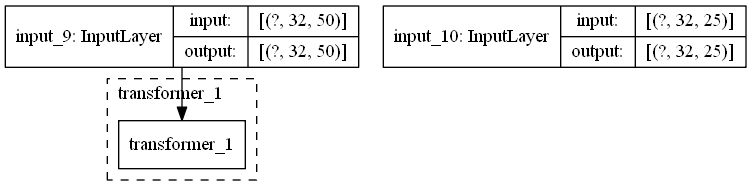

In [80]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)